# Project Disaster Tweets

This notebook was made on google collab. To use it at it's best please read it on collab and don't forget to upload the "train.csv" in your content folder.

## Part 1 : EDA and Preprocessing

In [236]:
#Librairies import
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
import numpy as np



EXPLORATORY DATA ANALYSIS

In [237]:
# Data file import
data = pd.read_csv('train.csv')
data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [238]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [239]:
data.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [240]:
#check of the target ratio
df = data.groupby('target').count()['id']
df.rename({0 : 'Not disasters' , 1: 'Real disasters'})
fig = px.pie(df, values= df.values , names = ('Not disasters' , 'Real disasters') , title = 'Ratio of real disasters vs fake ones')
fig.show()


In [241]:
data['text'].sample(40)

6294    @Coach_Keith44 @HannoMottola @TRPreston01 @mlr...
3540      @OCT336 guys these bitches ain't famine then ??
6350    @sabcnewsroom sabotage!I rule out structural f...
3024    Going to a fest? Bring swimming goggles for th...
746     they say bad things happen for a reason\nbut n...
6774    Tornado has to make the playoffs. They have 3 ...
5586    #News : The Latest: More Homes Razed by Northe...
5080    Is your team ready for a natural disaster a vi...
6933    Love how I don't get in any trouble for having...
3772                              Fire waves and darkness
3889    #Floored4 #Flattened \n\nEarly birds does get ...
7145                       @alextucker VOLCANO BOWL DRINK
1951    'The Big Ten has their annual football media d...
7550    Poor Liv and I getting our phones wrecked on t...
5929    *wants to make tweet about how much I dislike ...
7454    Woodlawn Shooting Wounds 79-Year-Old Woman Tee...
515     @MageAvexis &lt; things. And what if we get at...
2228    @Fiend

So we got a 7613 lines dataset with pretty complete lines except for location. The dataset target is quite balanced which is good for our work.

If we focus on the text data itself it looks like we have some special characters and links to work on.

DATA PREPROCESSING


In [242]:
#import english language to read the tweets

!python -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

2022-08-14 19:01:24.112015: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 13.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [243]:
#Import of stop words

stopwords = nlp.Defaults.stop_words
print(len(stopwords))

326


In [244]:
# cleaning of the text
data['text_cleaned'] = data['text'] .apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
data['text_cleaned'] = data['text_cleaned'].apply(lambda x: x.replace(" +"," ").lower().strip())
data['text_cleaned'] = data['text_cleaned'].str.replace(r"http.*","")
data['text_cleaned'] = data['text_cleaned'].str.replace(r"https.*","")
data['text_cleaned'] = data['text_cleaned'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in stopwords) & (token.text not in stopwords)]))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.



In [245]:
# quick check if our new column works
data.head()

,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...


In [246]:
# quick view of some cleaned data
data['text_cleaned'].sample(20)

7149                                  lexipurduee volcano
6659    build share custom application threatconnect w...
5681                     rescue med migrant arrive sicily
3124    pakistannew nankana sahib city news electrocut...
4833    flgovscott allow farrakhan   challenge 10000 m...
1963    severe weather bulletin 6tropical cyclone warn...
4068    campsite recommendation toilet shower pub fire...
1247    fire hazard associate installation noncomplian...
7406    twilight encore wound heart book 3 jacquie biggar
5417    feel like panic idk result week m alarmingly calm
53      police arsonist deliberately set black church ...
6686    heavy rain frequent thunder gusty wind uptown ...
6506             shit happen today wtf idk survive thruuu
5576                      way like rainstorm m house card
1463                cultivate joy face catastrophe suffer
977     å new lady shoulder tote handbag faux leather ...
6540    thesmallclark hell kill instead survive shot e...
5377          

In [247]:
# Tokening
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000) # instanciate the tokenizer
tokenizer.fit_on_texts(data['text_cleaned'])
data["text_encoded"] = tokenizer.texts_to_sequences(data['text_cleaned'])

In [248]:
data.head(10)

,id,keyword,location,text,target,text_cleaned,text_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[3479, 398, 226, 1337, 1868]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[126, 2, 157, 489, 5239, 5240, 1223]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1338, 425, 1640, 340, 5241, 275, 187, 1640, 3..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[2205, 7, 2206, 69, 187, 267, 34]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[246, 176, 127, 5242, 1641, 164, 69, 2207, 103]"
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy 20 close dir...,"[2208, 165, 34, 1224, 535, 305, 816, 764, 276,..."
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash flooding...,"[28, 16, 653, 154, 47, 612, 341, 380, 5244, 76..."
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,m hill fire wood,"[3, 1122, 2, 1642]"
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,s emergency evacuation happen building street,"[5, 14, 187, 170, 30, 380]"
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,m afraid tornado come area,"[3, 1869, 291, 12, 196]"


In [249]:
# Adding padding
text_pad = keras.preprocessing.sequence.pad_sequences(data['text_encoded'], padding="post")

In [250]:
text_pad


array([[3479,  398,  226, ...,    0,    0,    0],
       [ 126,    2,  157, ...,    0,    0,    0],
       [1338,  425, 1640, ...,    0,    0,    0],
       ...,
       [2567, 3475, 5209, ...,    0,    0,    0],
       [  23,  712, 2454, ...,    0,    0,    0],
       [ 104,   25,  365, ...,    0,    0,    0]], dtype=int32)

In [251]:
text_pad.shape


(7613, 25)

In [252]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(text_pad,data.target, test_size=0.3, random_state=42)

#Train and Val dataset creation
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [253]:
#Batch creation

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)


## Part 2 : Model building

FIRST MODEL

In [254]:
# Model creation
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Input Word Embedding layer          
                  tf.keras.layers.Embedding(vocab_size+1, 64,name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Dense layers
                  tf.keras.layers.Dense(32, activation='relu'),

                  tf.keras.layers.Dense(16, activation='relu'),

                  # output layers with sigmoid activation function as it's a binary classification case
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [255]:
# Optimizer and logs settings
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])

In [256]:
# CALLBACK OPTION 1
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [257]:
# CALLBACK OPTION 2
tensorboard_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [258]:
# quick check of the model
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 global_average_pooling1d_43  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_157 (Dense)           (None, 32)                2080      
                                                                 
 dense_158 (Dense)           (None, 16)                528       
                                                                 
 dense_159 (Dense)           (None, 1)                 17        
                                                                 
Total params: 642,689
Trainable params: 642,689
Non-trainable params: 0
_______________________________________________

In [259]:
# Training
history = model.fit(train_batch, 
                    epochs=50, 
                    validation_data=val_batch,
                    callbacks=[tensorboard_callback])

Epoch 1/50
84/84 [==============================] - 2s 13ms/step - loss: 0.6917 - binary_accuracy: 0.5418 - val_loss: 0.6889 - val_binary_accuracy: 0.5771
Epoch 2/50
84/84 [==============================] - 1s 13ms/step - loss: 0.6865 - binary_accuracy: 0.5675 - val_loss: 0.6831 - val_binary_accuracy: 0.5771
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 0.6811 - binary_accuracy: 0.5675 - val_loss: 0.6773 - val_binary_accuracy: 0.5771
Epoch 4/50
84/84 [==============================] - 2s 21ms/step - loss: 0.6751 - binary_accuracy: 0.5675 - val_loss: 0.6716 - val_binary_accuracy: 0.5771
Epoch 5/50
84/84 [==============================] - 2s 20ms/step - loss: 0.6684 - binary_accuracy: 0.5675 - val_loss: 0.6649 - val_binary_accuracy: 0.5775
Epoch 6/50
84/84 [==============================] - 2s 19ms/step - loss: 0.6590 - binary_accuracy: 0.5718 - val_loss: 0.6563 - val_binary_accuracy: 0.5884
Epoch 7/50
84/84 [==============================] - 2s 21ms/step - los

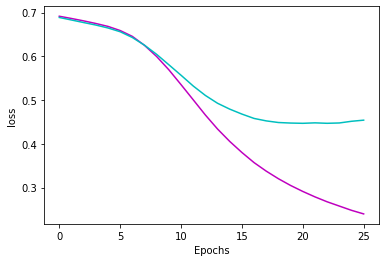

In [260]:
# Visualization of the training process for the loss
plt.plot(history.history["loss"], color="m")
plt.plot(history.history["val_loss"], color="c")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

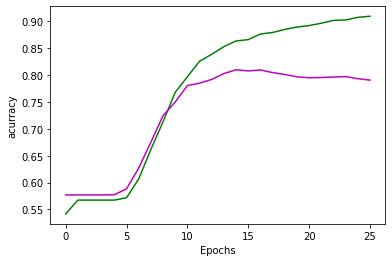

In [261]:
# Visualization of the training process for the accuracy
plt.plot(history.history["binary_accuracy"], color="g")
plt.plot(history.history["val_binary_accuracy"], color="m")
plt.ylabel("acurracy")
plt.xlabel("Epochs")
plt.show()

The first model stops at:
Epoch 26/50
84/84 [==============================] - 1s 11ms/step - loss: 0.2399 - binary_accuracy: 0.9096 - val_loss: 0.4542 - val_binary_accuracy: 0.7907

Those results are not too bad but the validation loss is quite high and we're over fitting.

SECOND MODEL : let's see what happen if we add some layers


In [262]:
model2 = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 256,name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(128, activation='relu'),

                  # Couche Dense classique
                  tf.keras.layers.Dense(64, activation='relu'),

                  # Couche Dense classique
                  tf.keras.layers.Dense(32, activation='relu'),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])

In [263]:
history = model2.fit(train_batch, 
                    epochs=50, 
                    validation_data=val_batch,
                    callbacks=[tensorboard_callback])

Epoch 1/50
84/84 [==============================] - 60s 38ms/step - loss: 0.6784 - binary_accuracy: 0.5673 - val_loss: 0.6641 - val_binary_accuracy: 0.5771
Epoch 2/50
84/84 [==============================] - 3s 35ms/step - loss: 0.6193 - binary_accuracy: 0.6373 - val_loss: 0.5591 - val_binary_accuracy: 0.7548
Epoch 3/50
84/84 [==============================] - 3s 35ms/step - loss: 0.4443 - binary_accuracy: 0.8356 - val_loss: 0.4681 - val_binary_accuracy: 0.8047
Epoch 4/50
84/84 [==============================] - 3s 35ms/step - loss: 0.3169 - binary_accuracy: 0.8752 - val_loss: 0.4676 - val_binary_accuracy: 0.7968
Epoch 5/50
84/84 [==============================] - 5s 60ms/step - loss: 0.2582 - binary_accuracy: 0.8974 - val_loss: 0.4842 - val_binary_accuracy: 0.7894
Epoch 6/50
84/84 [==============================] - 3s 39ms/step - loss: 0.2249 - binary_accuracy: 0.9127 - val_loss: 0.5040 - val_binary_accuracy: 0.7898
Epoch 7/50
84/84 [==============================] - 3s 36ms/step - lo

The second model stops at:  Epoch 9/50
84/84 [==============================] - 3s 34ms/step - loss: 0.1605 - binary_accuracy: 0.9356 - val_loss: 0.5743 - val_binary_accuracy: 0.7750

those results are very similar, maybe tiny bit less good.

THIRD MODEL : we are going to try to reduce over fitting with some regularization

In [264]:
# Model creation: we take the first model and we add the regularization parameter L2

model3 = tf.keras.Sequential([
                  # Input Word Embedding layer          
                  tf.keras.layers.Embedding(vocab_size+1, 64,name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Dense layers
                  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.001)),

                  tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.001)),

                  # output layers with sigmoid activation function as it's a binary classification case
                  tf.keras.layers.Dense(1, activation="sigmoid")

])

model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])

In [265]:
# Training
history = model3.fit(train_batch, 
                    epochs=50, 
                    validation_data=val_batch,
                    callbacks=[tensorboard_callback])

Epoch 1/50
84/84 [==============================] - 2s 14ms/step - loss: 0.9803 - binary_accuracy: 0.5524 - val_loss: 0.9350 - val_binary_accuracy: 0.5771
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.9081 - binary_accuracy: 0.5675 - val_loss: 0.8831 - val_binary_accuracy: 0.5771
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.8646 - binary_accuracy: 0.5675 - val_loss: 0.8468 - val_binary_accuracy: 0.5771
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.8325 - binary_accuracy: 0.5675 - val_loss: 0.8189 - val_binary_accuracy: 0.5771
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.8066 - binary_accuracy: 0.5676 - val_loss: 0.7958 - val_binary_accuracy: 0.5775
Epoch 6/50
84/84 [==============================] - 1s 13ms/step - loss: 0.7846 - binary_accuracy: 0.5703 - val_loss: 0.7762 - val_binary_accuracy: 0.5806
Epoch 7/50
84/84 [==============================] - 1s 12ms/step - los

This thrid model stops at: Epoch 33/50
84/84 [==============================] - 1s 12ms/step - loss: 0.3644 - binary_accuracy: 0.9043 - val_loss: 0.5446 - val_binary_accuracy: 0.7964

Results are very similar with the first one.

At the end, within the tested models, the first one is probably the best one.
